For this code all credit goes to Laurie Shaw from Friends of Tracking: https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking

I changed his code a bit in Metrica_PitchControl to create a method called "generate_pitch_control_tracking" which allowed me to plot tracking data not event data. You can find the definitition for the function to put into Metrica_PitchControl at the very bottom of the notebook or just run it from the notebook and remove "mpc."

In [1]:
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import Metrica_PitchControl as mpc
import numpy as np
import matplotlib.pyplot as plt

# Set the path and game_id
DATADIR = r'C:\Users\paul9977\Documents\Projects\Soccer Analytics\Friends of Tracking\LaurieOnTracking\sample-data-master\data'
game_id=2

# read in the event data
events = mio.read_event_data(DATADIR,game_id)

# read in tracking data
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True,filter_='moving_average')
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True,filter_='moving_average')

Reading team: home
Reading team: away


In [2]:
params = mpc.default_model_params(3)
cmap = 'bwr'

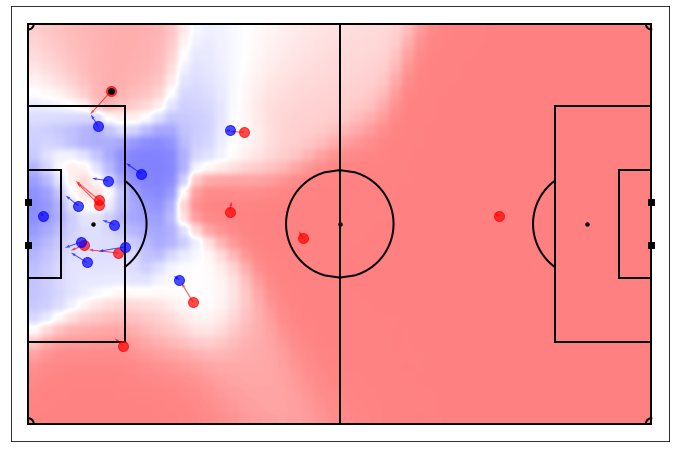

In [3]:
frame = 12160
PPCF,xgrid,ygrid = mpc.generate_pitch_control_tracking(frame, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
fig,ax = mviz.plot_pitch(field_color='white', field_dimen = (106, 68))
mviz.plot_frame(tracking_home.loc[frame], tracking_away.loc[frame], figax=(fig,ax), include_player_velocities=True)
ax.imshow(np.flipud(PPCF), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),interpolation='hanning',vmin=0.0,vmax=1.0,cmap=cmap,alpha=0.5)
plt.show()

This next cell creates all the images and takes a good amount of time to run. Good Luck!

(Commented out because GitHub gets mad if now)

In [4]:
plt.rcParams.update({'figure.max_open_warning': 0})
frames = range(11647, 12300)
for frame in frames:
    PPCF,xgrid,ygrid = mpc.generate_pitch_control_tracking(frame, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
    fig,ax = mviz.plot_pitch(field_color='white', field_dimen = (106, 68))
    mviz.plot_frame(tracking_home.loc[frame], tracking_away.loc[frame], figax=(fig,ax), include_player_velocities=True)
    ax.imshow(np.flipud(PPCF), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),interpolation='hanning',vmin=0.0,vmax=1.0,cmap=cmap,alpha=0.5)
    plt.savefig(f'Pitch Control Pics\Pitch_Control_{frame}.jpg')

Then run:

ffmpeg -start_number 11647 -i Pitch_Control_%05d.jpg Pitch_Control.avi

#### Edit to Laurie's Metrica_PitchControl

In [5]:
# def generate_pitch_control_tracking(tracking_id, tracking_home, tracking_away, params, field_dimen = (106.,68.,), n_grid_cells_x = 50):
#     """ generate_pitch_control_tracking
    
#     Evaluates pitch control surface over the entire field at the moment of the given tracking data frame
    
#     Parameters
#     -----------
#         tracking_id: Index (not row) of the tracking data that describes the instant at which the pitch control surface should be calculated
#         tracking_home: tracking DataFrame for the Home team
#         tracking_away: tracking DataFrame for the Away team
#         params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
#         field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
#         n_grid_cells_x: Number of pixels in the grid (in the x-direction) that covers the surface. Default is 50.
#                         n_grid_cells_y will be calculated based on n_grid_cells_x and the field dimensions
        
#     Returrns
#     -----------
#         PPCFa: Pitch control surface (dimen (n_grid_cells_x,n_grid_cells_y) ) containing pitch control probability for the attacking team.
#                Surface for the defending team is just 1-PPCFa.
#         xgrid: Positions of the pixels in the x-direction (field length)
#         ygrid: Positions of the pixels in the y-direction (field width)

#     """
#     # get the details of the event (frame, team in possession, ball_start_position)
#     frame = tracking_id
#     pass_team = "Home"
#     ball_start_pos = np.array([tracking_home.iloc[tracking_id]['ball_x'],tracking_home.iloc[tracking_id]['ball_y']])
#     # break the pitch down into a grid
#     n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
#     xgrid = np.linspace( -field_dimen[0]/2., field_dimen[0]/2., n_grid_cells_x)
#     ygrid = np.linspace( -field_dimen[1]/2., field_dimen[1]/2., n_grid_cells_y )
#     # initialise pitch control grids for attacking and defending teams 
#     PPCFa = np.zeros( shape = (len(ygrid), len(xgrid)) )
#     PPCFd = np.zeros( shape = (len(ygrid), len(xgrid)) )
#     # initialise player positions and velocities for pitch control calc (so that we're not repeating this at each grid cell position)
#     if pass_team=='Home':
#         attacking_players = initialise_players(tracking_home.loc[frame],'Home',params)
#         defending_players = initialise_players(tracking_away.loc[frame],'Away',params)
#     elif pass_team=='Away':
#         defending_players = initialise_players(tracking_home.loc[frame],'Home',params)
#         attacking_players = initialise_players(tracking_away.loc[frame],'Away',params)
#     else:
#         assert False, "Team in possession must be either home or away"
#     # calculate pitch pitch control model at each location on the pitch
#     for i in range( len(ygrid) ):
#         for j in range( len(xgrid) ):
#             target_position = np.array( [xgrid[j], ygrid[i]] )
#             PPCFa[i,j],PPCFd[i,j] = calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, params)
#     # check probabilitiy sums within convergence
#     checksum = np.sum( PPCFa + PPCFd ) / float(n_grid_cells_y*n_grid_cells_x ) 
#     assert 1-checksum < params['model_converge_tol'], "Checksum failed: %1.3f" % (1-checksum)
#     return PPCFa,xgrid,ygrid